In [1]:
import os
import glob
import io
import pandas as pd
import tableprint
import sys
from io import StringIO
import json

### All 247 Site Keys and their corresponding Team Names 

In [2]:
#Found = [24248320, 25100288, 25165824, 2490368, 24444928, 25624576, 25493504, 24707072, 24969216, 25231360, 24051712, 2097152, 23920640,24379392,24313856, 25427968, 25362432, 24903680, 23986176, 23855104, 24117248, 23789568, 24641536, 24838144, 24576000, 24510464, 24182784, 25034752, 25690112, 24772608, 25296896, 23724032]

team_dict = {24248320: 'Cowboys',
25100288 : 'Raiders',
25165824 : 'Eagles',
2490368 : 'Seahawks',
24444928 : 'Packers',
25624576 : 'Saints',
25493504 : 'Redskins',
24707072 : 'Chiefs',
24969216 : 'Giants',
25231360 : 'Steelers',
24051712 : 'Bears',
2097152 : 'Titans',
23920640 : 'Buffalo',
24379392 : 'Lions',
24313856 : 'Broncos',
25427968 : 'Rams',
25362432 : '49ers',
24903680 : 'Patriots',
23986176 : 'Panthers',
23855104 : 'Ravens',
24117248 : 'Bengals',
23789568 : 'Falcons',
24641536 : 'Jaguars',
24838144 : 'Vikings',
24576000 : 'Colts',
24510464 : 'Texans',
24182784 : 'Browns',
25034752 : 'Jets',
25690112 : 'Bucs',
24772608 : 'Dolphins',
25296896 : 'Chargers',
23724032 : 'Cardinals'}

dict_site = team_dict.keys()
dict_team = team_dict.values()


### Reading all files from Sunday, October 8, 2017

In [3]:
Sunday_big_df = [[]]
files = []
for root, dirs, files in os.walk('rawdata/10-08/'):
    files += glob.glob(os.path.join(root, '*.*'))

Sunday_big_df = pd.DataFrame()
df_working_clean = []

for i in files: 
    temp = open('rawdata/10-08/'+i,'r', encoding="utf-8")
    df_working = temp.read()
    df_working = df_working.replace('}{', '}\n{')
    df_working = df_working.splitlines()
    
    for record in df_working:
        rec = json.loads('{' + record[1:-1] + '}')
        df_working_clean.append(rec)


In [4]:
## data cleaning - no need for extra fields, reducing df size ##
df_temp = pd.DataFrame(df_working_clean)
df_temp = df_temp.drop(['authorKey', 'contentKey', 'pathRoot', 'publishedDate', 'referrer','userAgent', 'userId'], axis=1)
df_temp['visit_hr'] = df_temp['timeStamp'].astype(str).str[-12:-10]
df_temp['visit_min'] = df_temp['timeStamp'].astype(str).str[-11:-9]
df_temp = df_temp[df_temp.siteKey.isin(dict_site)]
Sunday_big_df = pd.DataFrame(Sunday_big_df.append(df_temp, ignore_index = True))    

### Reading all files from Monday, October 9, 2017
#### Because UTC, all Sunday activity after 6pm is shown in Monday 0000 - 0600

In [5]:
Monday_big_df = [[]]
files = []
for root, dirs, files in os.walk('rawdata/10-09/'):
    files += glob.glob(os.path.join(root, '*.*'))

Monday_big_df = pd.DataFrame()
df_working_clean = []

for i in files: 
    temp2 = open('rawdata/10-09/'+i,'r', encoding="utf-8")
    df_working = temp2.read()
    df_working = df_working.replace('}{', '}\n{')
    df_working = df_working.splitlines()
    
    for record in df_working:
        rec = json.loads('{' + record[1:-1] + '}')
        df_working_clean.append(rec)

In [6]:
## data cleaning - no need for extra fields, reducing df size ##
df_temp = pd.DataFrame(df_working_clean)
df_temp = df_temp.drop(['authorKey', 'contentKey', 'pathRoot', 'publishedDate', 'referrer','userAgent', 'userId'], axis=1)
df_temp['visit_hr'] = df_temp['timeStamp'].astype(str).str[-12:-10]
df_temp['visit_min'] = df_temp['timeStamp'].astype(str).str[-11:-9]
df_temp = df_temp[df_temp.siteKey.isin(dict_site)]
Monday_big_df = pd.DataFrame(Monday_big_df.append(df_temp, ignore_index = True))    

### Data Aggregation performed for Sunday and Monday before combining

In [7]:
Sunday = Sunday_big_df.groupby(['siteKey','visit_hr'], as_index=False).count()
Sunday['counts'] = Sunday['timeStamp']
Sunday = Sunday.drop(['timeStamp'], axis=1)
Sunday = Sunday.drop(['visit_min'], axis=1)
Sunday = Sunday.drop(['userStatus'], axis=1)
Sunday['visit_hr'] = (Sunday['visit_hr'].apply(pd.to_numeric))-6  # adjusting UTC to CST during DST
Sunday = Sunday[Sunday.visit_hr > 0]

In [8]:
Monday = Monday_big_df.groupby(['siteKey','visit_hr'], as_index=False).count()
Monday['counts'] = Monday['timeStamp']
Monday = Monday.drop(['timeStamp'], axis=1)
Monday = Monday.drop(['visit_min'], axis=1)
Monday = Monday.drop(['userStatus'], axis=1)

# need to add 18 to account for Sunday night hours
Monday['visit_hr'] = (Monday['visit_hr'].apply(pd.to_numeric))+18  # adjusting UTC to CST during DST
Monday = Monday[Monday.visit_hr < 24]

In [9]:
frames = [Sunday,Monday]
Sunday_full = pd.concat(frames)
Sunday_full = Sunday_full.dropna(subset = ['visit_hr'])
Sunday_full['siteKey'] = Sunday_full['siteKey'].replace(dict_site, dict_team)

### Plotting hourly visits by team for Sunday, October 8, 2017.
### Trends show early morning visits followed by game time activity

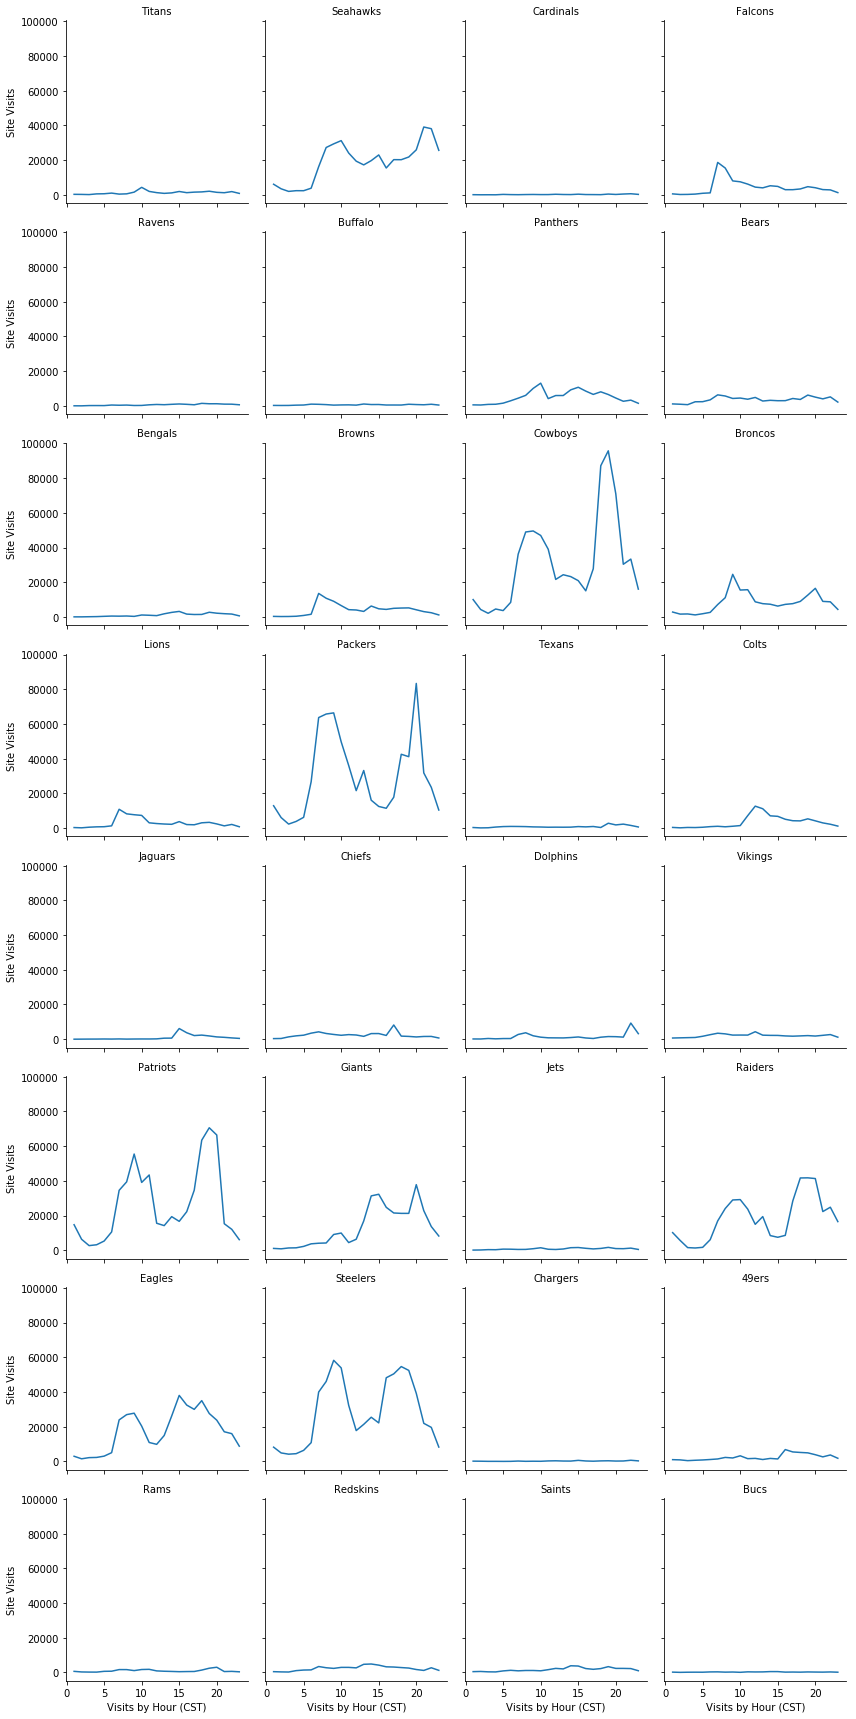

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

g = sns.FacetGrid(Sunday_full, col='siteKey', col_wrap=4)
g = g.map(plt.plot, 'visit_hr', 'counts').set_axis_labels("Visits by Hour (CST)", "Site Visits").set_titles("{col_name}")


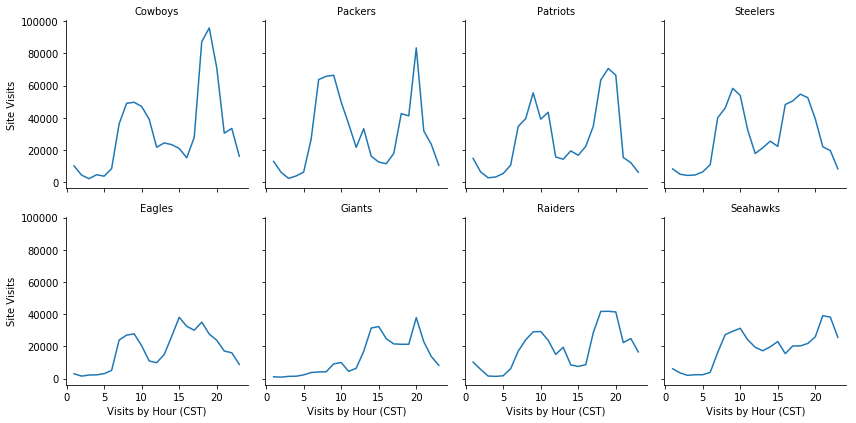

In [28]:
top_teams = ('Cowboys', 'Packers', 'Patriots', 'Steelers', 'Eagles', 'Giants', 'Raiders', 'Seahawks')

g2 = sns.FacetGrid(Sunday_full, col='siteKey', col_wrap=4, col_order = top_teams)
g2 = g2.map(plt.plot, 'visit_hr', 'counts').set_axis_labels("Visits by Hour (CST)", "Site Visits").set_titles("{col_name}")
